In [1]:
from methods.meta_opt_heads import ClassificationHead
# from methods.prototypical_networks import PrototypicalNetworks as Method
# from methods.matching_networks import MatchingNetworks as Method

In [2]:
import time
import timm
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from trainer import train_metaopt_step, validate_metaopt
from data.data_manager import BRSETManager

In [3]:
TRAINING_CLASSES = ['diabetic_retinopathy',
                        'scar', 'amd', 'hypertensive_retinopathy', 'drusens', 
                        'myopic_fundus', 'increased_cup_disc', 'other']
TEST_CLASSES = ['hemorrhage', 'vascular_occlusion', 'nevus', 'healthy']

In [4]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(1)
device

device(type='cuda', index=1)

In [5]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
ways = 2
shots = 5
model_type = 'resnet50.a3_in1k'

batch_size = ways*shots

### Modelo

In [7]:
def get_model(embedding_net):
    # Choose the embedding network
    backbone = timm.create_model(embedding_net, pretrained=True)
    backbone.reset_classifier(num_classes=0)

    cls_head = ClassificationHead(base_learner='SVM-CS').cuda()
        
    return (backbone, cls_head)

In [8]:
(embedding_net, cls_head) = get_model(embedding_net=model_type)
embedding_net.to(device)
cls_head.to(device)

ClassificationHead()

In [9]:
if model_type == "resnet50.a3_in1k" or model_type == "swin_s3_tiny_224.ms_in1k": 
    mean_val, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
elif model_type == "vit_small_patch32_224.augreg_in21k_ft_in1k":
    mean_val, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [10]:
manager = BRSETManager(TRAINING_CLASSES, TEST_CLASSES, shots, ways, mean_val, std, 
                       augment=None, batch_size=batch_size, seed=seed)

In [11]:
optimizer = torch.optim.Adam([{'params': embedding_net.parameters()}, 
                            {'params': cls_head.parameters()}], lr=1e-4)

criterion = nn.CrossEntropyLoss()

episodes = 500
epochs = 20
validate_every = 2

In [12]:
train_logs = []
val_logs = []

embedding_net.train()
cls_head.train()
start_time = time.time()

for epoch in range(epochs):
    total_loss, total_acc = 0, 0
    train_time = time.time()

    # treinamento
    embedding_net.train()
    cls_head.train()
    for episode in range(episodes):
        loss, acc = train_metaopt_step(manager, embedding_net, cls_head, optimizer, criterion, device)
        total_loss += loss
        total_acc += acc
        print(f'Episodio {episode + 1}/{episodes}', end='\r')

    loss = total_loss / episodes
    acc = total_acc / episodes
    print(f"Epoch {epoch + 1} - Loss: {loss:.3f} - Acc: {acc:.2f} - Tempo: {time.time() - train_time:.0f}s")
    train_logs.append((epoch + 1, loss, acc))

    # validacao
    if (epoch + 1) % validate_every == 0:
        val_time = time.time()
        embedding_net.eval()
        cls_head.eval()

        val_loss, val_acc = validate_metaopt(manager, embedding_net, cls_head, criterion, device)
        print(f"Validation - Loss: {val_loss:.3f} - Acc: {val_acc:.2f} - Tempo: {time.time() - val_time:.0f}s\n")
        val_logs.append((epoch + 1, val_loss, val_acc))
        
print(f'\nDemorou: {time.time() - start_time:.2f}s')

Epoch 1 - Loss: 1.517 - Acc: 0.63 - Tempo: 181s
Epoch 2 - Loss: 1.445 - Acc: 0.74 - Tempo: 192s
Validation - Loss: 1.523 - Acc: 0.63 - Tempo: 54s

Epoch 3 - Loss: 1.384 - Acc: 0.78 - Tempo: 202s
Epoch 4 - Loss: 1.304 - Acc: 0.84 - Tempo: 206s
Validation - Loss: 1.493 - Acc: 0.67 - Tempo: 51s

Epoch 5 - Loss: 1.271 - Acc: 0.84 - Tempo: 203s
Epoch 6 - Loss: 1.223 - Acc: 0.86 - Tempo: 198s
Validation - Loss: 1.507 - Acc: 0.66 - Tempo: 50s

Epoch 7 - Loss: 1.181 - Acc: 0.89 - Tempo: 199s
Epoch 8 - Loss: 1.184 - Acc: 0.87 - Tempo: 200s
Validation - Loss: 1.481 - Acc: 0.67 - Tempo: 45s

Epoch 9 - Loss: 1.132 - Acc: 0.90 - Tempo: 193s
Epoch 10 - Loss: 1.094 - Acc: 0.92 - Tempo: 194s
Validation - Loss: 1.497 - Acc: 0.65 - Tempo: 50s

Epoch 11 - Loss: 1.122 - Acc: 0.91 - Tempo: 197s
Epoch 12 - Loss: 1.092 - Acc: 0.91 - Tempo: 203s
Validation - Loss: 1.488 - Acc: 0.66 - Tempo: 47s

Epoch 13 - Loss: 1.094 - Acc: 0.91 - Tempo: 197s
Epoch 14 - Loss: 1.097 - Acc: 0.90 - Tempo: 201s
Validation - Loss

In [18]:
train_epochs = [metric[0] for metric in train_logs]
train_loss   = [metric[1].item() if torch.is_tensor(metric[1]) else metric[1] for metric in train_logs]
train_acc    = [metric[2].item() if torch.is_tensor(metric[2]) else metric[2] for metric in train_logs]

val_epochs = [metric[0] for metric in val_logs]
val_loss   = [metric[1].item() if torch.is_tensor(metric[1]) else metric[1] for metric in val_logs]
val_acc    = [metric[2].item() if torch.is_tensor(metric[2]) else metric[2] for metric in val_logs]


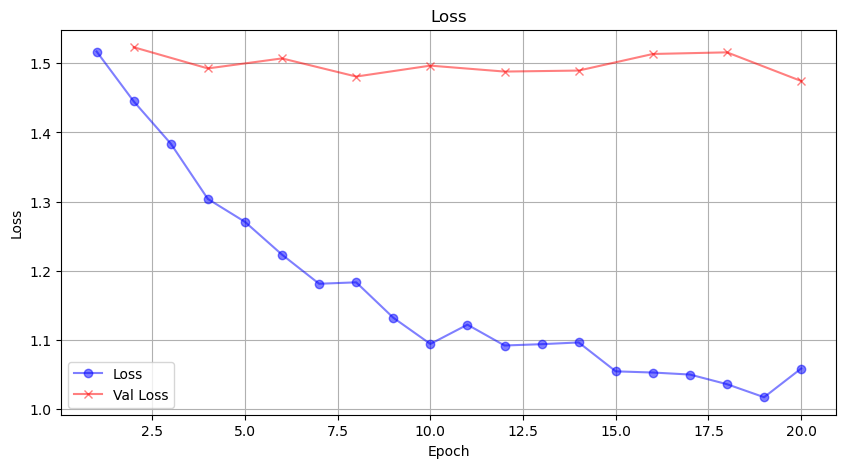

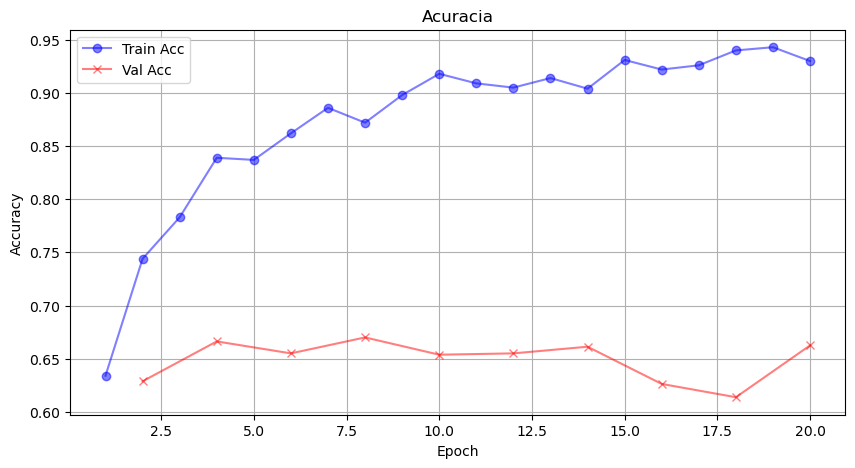

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(train_epochs, train_loss, marker='o', color='blue', label="Loss", alpha=0.5)
plt.plot(val_epochs, val_loss, marker='x', color='red', label="Val Loss", alpha=0.5)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_epochs, train_acc, marker='o', color='blue', label="Train Acc", alpha=0.5)
plt.plot(val_epochs, val_acc, marker='x', color='red', label="Val Acc", alpha=0.5)
plt.title("Acuracia")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()